# <span style="background-color: lightcyan;">Brain Tumor Imaging Classification for Early Detection</span>

[Problem Identification](#Problem-Identification)- In this step I explain what the problem is and what the process to solve the problesm is. 

[Data Wrangling](#Data-Wrangling) - In this step I loaded te data and familiarized myself with it. This helped me identify issues I could face when dealing with the data.  I performed several preprocessing techniques, including standardization, resizing, normalization, and contrast enhancements. Additionally, I conducted a metadata analysis to assess the structure and integrity of the dataset, ensuring its readiness for exploratory and modeling tasks.

[Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))- In this step I vizualised data characteristics to further understand the images and data features Im dealing with. 



## Problem Identification

**<span style="color: lightcoral;">Problem Identification</span>**


The client, NeuroScan Diagnostics, is a leading healthcare provider specializing in medical imaging and early disease detection. One of the biggest challenges in brain tumor diagnosis is the accurate and timely classification of tumors based on MRI scans. Misclassification or delayed detection can lead to incorrect treatment plans, increasing risks for patients.
To address this, NeuroScan Diagnostics seeks to implement an AI-powered deep learning model capable of identifying glioma tumors, meningioma tumors, pituitary tumors, or no tumor based on brain images. By integrating a robust classification system, the organization aims to support radiologists with automated tumor detection, improving diagnostic precision and reducing manual workload. A reliable deep learning model must be developed and deployed by the end of the fiscal year to ensure readiness for clinical validation and real world applications.



## Data Wrangling & Pre-Processing

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam



add original images before tweaks 

**<span style="color: lightcoral;">Standardize</span>**: image sizes to maintain uniformity across the dataset.

**<span style="color: lightcoral;">Resizing</span>** : Adjust images to a fixed size for model compatibility.

**<span style="color: lightcoral;">Normalization</span>**: Scale pixel values (e.g., between 0 and 1) to improve model performance.

**<span style="color: lightcoral;">Contrast Enhancement</span>**: Apply techniques like histogram equalization to improve visibility.

**<span style="color: lightcoral;">Metadata Analysis</span>**: Check image formats, dimensions, and color channels.




In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']



In [3]:
X_train = []
y_train = []

image_size = 224
for i in labels:
    folderPath = os.path.join('dataset_extracted/Tumor Data', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(image_size, image_size))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)  # Apply CLAHE for controlled contrast enhancement
        img = img / 255.0  # Normalize pixel values to range [0, 1]
        X_train.append(img)
        y_train.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 827/827 [00:00<00:00, 1234.33it/s]


In [4]:
X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join('dataset_extracted/Tumor Data', 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(image_size, image_size))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)  # Apply CLAHE for controlled contrast enhancement
        img = img / 255.0  # Normalize pixel values to range [0, 1]
        X_test.append(img)
        y_test.append(i)

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 725.47it/s]


In these two cells the trainign data and testing data where extracted, standardised, resized and normalized for bettere accuracy trainig of the model. 

In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test =  np.array(y_test)

Here the training and testing lists are turned into NumPy arrays because deep learning models, like CNNs that I'll be using , work with numerical tensors not lists or raw images.



## Exploratory Data Analysis (EDA)

**<span style="color: lightcoral;"> Data Quality Assessment</span>**

- To begin EDA I will do a **Visual Inspection** and display random images from the training and testing data. They both look great. I dont see any anomalities. 

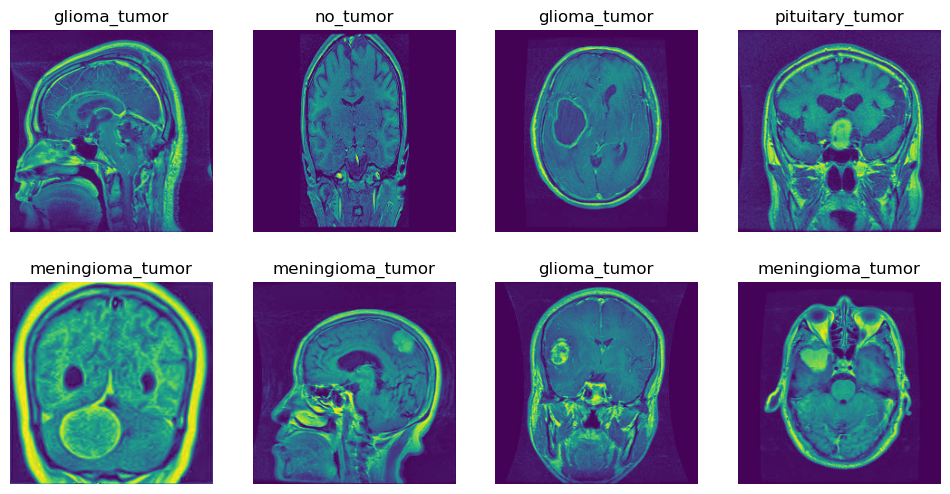

In [6]:
num_images = 8
indices = np.random.choice(len(X_train), num_images, replace=False)

plt.figure(figsize=(12,6))
for i, idx in enumerate(indices):
    plt.subplot(2, 4, i+1) 
    plt.imshow(X_train[idx])
    plt.title(y_train[idx])  
    plt.axis('off')

plt.show()


Here I'm just taking a look at how my images are looking so I can Porceed with new techniques. 

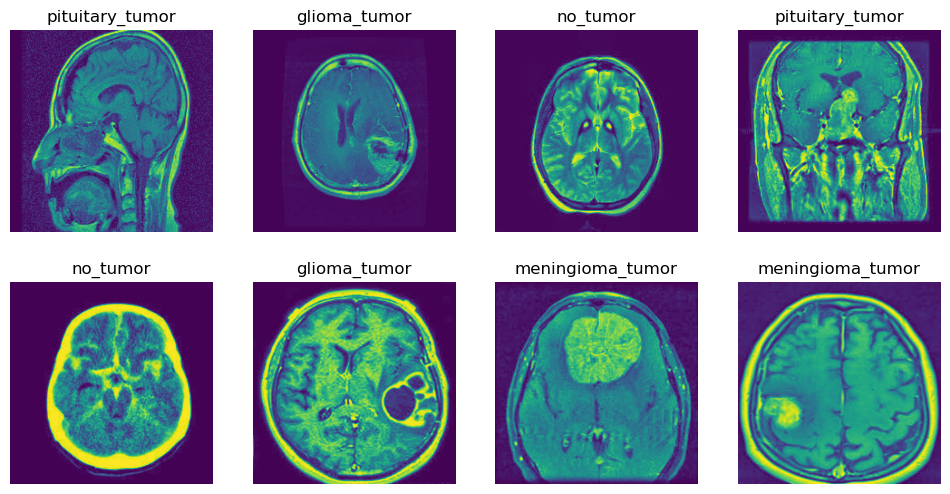

In [7]:
num_images = 8
indices_2 = np.random.choice(len(X_test), num_images, replace=False)

plt.figure(figsize=(12,6))
for i, idx in enumerate(indices_2):
    plt.subplot(2, 4, i+1)  
    plt.imshow(X_test[idx])
    plt.title(y_test[idx])  
    plt.axis('off')

plt.show()


**<span style="color: lightcoral;">Image Count Per Class</span>**: Ensure balanced class distribution to avoid bias.



In [8]:
X_train.shape

(3310, 224, 224)

In [9]:
y_train.shape

(3310,)

In [10]:
y_train_df =  pd.DataFrame(y_train)
y_train_df.head()

,0
0,glioma_tumor
1,glioma_tumor
2,glioma_tumor
3,glioma_tumor
4,glioma_tumor


In [11]:
y_train_df.value_counts()

0               
no_tumor            835
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
Name: count, dtype: int64

The dataset shows to be quite balanced! I do not need to balance the dataset because all categories fall in the same range. 

In [12]:
X_test.shape

(394, 224, 224)

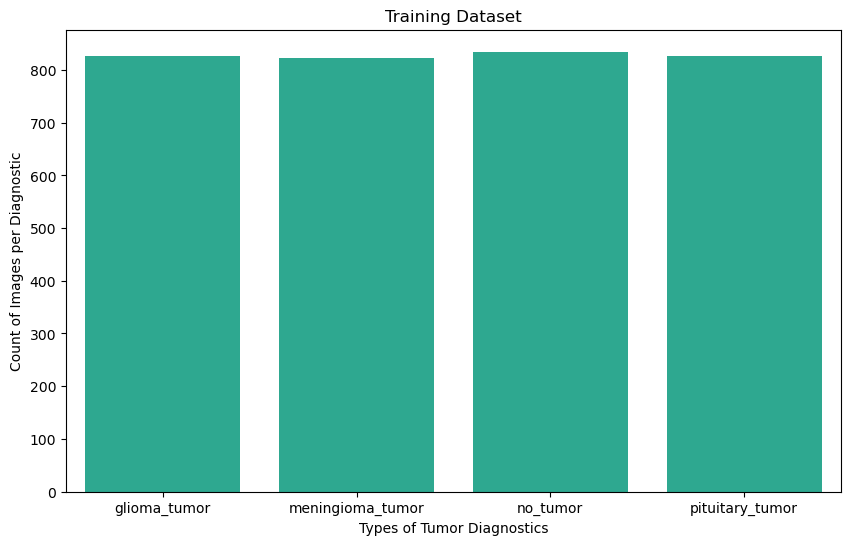

In [13]:
plt.figure(figsize = (10,6))
sns.countplot(x = y_train_df.iloc[:,0], color='#1abc9c')
plt.xlabel("Types of Tumor Diagnostics")
plt.ylabel("Count of Images per Diagnostic")
plt.title("Training Dataset")
plt.show()

**<span style="color: lightcoral;">Bar Chart of Class Frequencies</span>**: Identify underrepresented categories.


In [14]:
y_test.shape

(394,)

In [15]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,0
0,glioma_tumor
1,glioma_tumor
2,glioma_tumor
3,glioma_tumor
4,glioma_tumor


In [16]:
y_test_df.value_counts()

0               
meningioma_tumor    115
no_tumor            105
glioma_tumor        100
pituitary_tumor      74
Name: count, dtype: int64

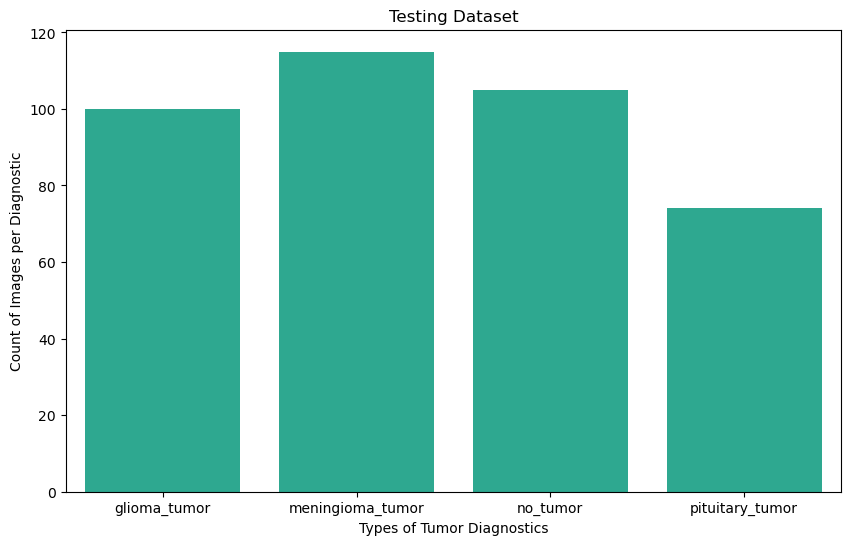

In [17]:
plt.figure(figsize = (10,6))
sns.countplot(x = y_test_df.iloc[:,0], color='#1abc9c')
plt.xlabel("Types of Tumor Diagnostics")
plt.ylabel("Count of Images per Diagnostic")
plt.title("Testing Dataset")
plt.show()

The testing data on the otherhand is quite unbalanced. Evaluation techniques like precision, recall, and F1-score, because they account for class imbalance.

**<span style="color: lightcoral;">Color & Pixel Distribution</span>**

**<span style="color: lightcoral;">Heatmaps</span>**: Visualize pixel intensity variations across images.

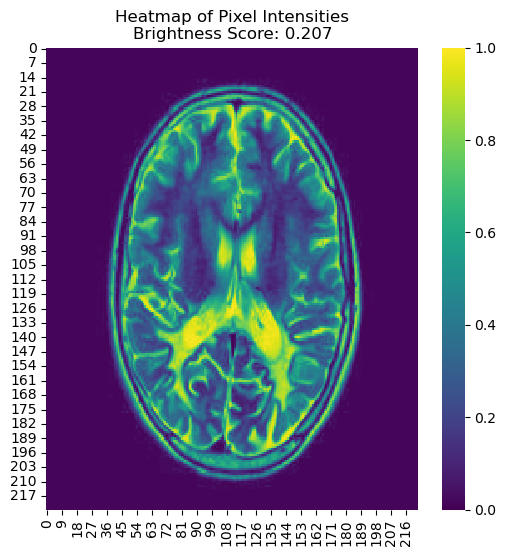

In [18]:
random_img = random.choice(X_train)

# Compute brightness score
brightness_score = np.mean(random_img)  # Average pixel intensity (0-1 scaled)

plt.figure(figsize=(6,6))
sns.heatmap(random_img, cmap="viridis")
plt.title(f"Heatmap of Pixel Intensities\nBrightness Score: {brightness_score:.3f}")
plt.show()



Every time this cell is executed it will run a picture with its brightness score. Higher brightness scores mean theres a higher chance of a tumor being present. 

**<span style="color: lightcoral;">Prepare Images (X data) as 3-channel RGB</span>**

The models Ill be using require for the image data they are fed to be 3 color channels and the images are curently 1. 


In [19]:
X_train_rgb = np.stack([X_train]*3, axis=-1)
X_test_rgb = np.stack([X_test]*3, axis=-1)


In [20]:
X_train_rgb.shape

(3310, 224, 224, 3)

In [21]:
X_test_rgb.shape

(394, 224, 224, 3)

**<span style="color: lightcoral;">Transform labeled data (y data) into numerical</span>**


In [22]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

y_test_encoded = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_encoded, num_classes=4)

y_test_cat = to_categorical(y_test_encoded, num_classes=4)

In [23]:
print(label_encoder.classes_)


['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


## Model Selection & Training

**<span style="color: lightcoral;">ResNet50</span>**


In [24]:
res_net_model = ResNet50(include_top =False, weights = 'imagenet', 
                        input_shape=(224,224,3))
# Freeze base layers
res_net_model.trainable = False

# Add custom classifier
x = res_net_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.25)(x)
output = Dense(4, activation='softmax')(x)

model_res_net = Model(inputs=res_net_model.input, outputs=output)

model_res_net.compile(
    optimizer='adam',
   loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [25]:
history = model_res_net.fit(
    X_train_rgb, y_train_cat, 
    epochs=5,
    batch_size=32
)


Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 326ms/step - accuracy: 0.2865 - loss: 1.6078
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 329ms/step - accuracy: 0.4037 - loss: 1.2640
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 326ms/step - accuracy: 0.4759 - loss: 1.1914
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 327ms/step - accuracy: 0.4827 - loss: 1.1664
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 330ms/step - accuracy: 0.5338 - loss: 1.1154


**<span style="color: lightcoral;">DenseNet121</span>**



In [26]:
dense_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Freeze base layers
dense_model.trainable = False

# Add custom classifier
x2 = dense_model.output
x2 = layers.Dense(64, activation='relu')(x2)
x2 = layers.Dropout(0.5)(x2)
outputs_2 = layers.Dense(4, activation='softmax')(x2)

model_densenet = models.Model(inputs=dense_model.input, outputs=outputs_2)

# Compile the model
model_densenet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [27]:
model_densenet_history = model_densenet.fit(
    X_train_rgb, y_train_cat,
    epochs= 5,
    batch_size=32,
    shuffle=True
)


Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 296ms/step - accuracy: 0.4953 - loss: 1.1913
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.7584 - loss: 0.6536
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 297ms/step - accuracy: 0.7999 - loss: 0.5393
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.8119 - loss: 0.4928
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.8212 - loss: 0.4771


**<span style="color: lightcoral;">Xception</span>**


In [28]:
xception_model = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

# Freeze base layers
xception_model.trainable = False

# Add custom classifier
x3 = xception_model.output
x3= GlobalAveragePooling2D()(x3)
x3_= layers.Dense(64, activation='relu')(x3) 
x3 = Dropout(0.3)(x3)
output_3 = Dense(4, activation='softmax')(x3)

model_xception = Model(inputs=xception_model.input, outputs=output_3)
model_xception.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
history_xception = model_xception.fit(
    X_train_rgb, y_train_cat, 
    epochs= 5,
    batch_size=32
)

Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 403ms/step - accuracy: 0.5623 - loss: 1.0237
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.8219 - loss: 0.5138
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 409ms/step - accuracy: 0.8405 - loss: 0.4518
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 415ms/step - accuracy: 0.8525 - loss: 0.4144
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - accuracy: 0.8708 - loss: 0.3693


**Making Predictions for All Models**

In [30]:
def predictions(model, train_data):
    probs = model.predict(train_data)
    return np.argmax(probs, axis=1)  # Return encoded labels directly

**<span style="color: lightcoral;">ResNet50 Model Predictions</span>**


In [31]:
ResNet_pred = predictions(model_res_net, X_train_rgb)
ResNet_pred

104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 337ms/step


array([1, 1, 0, ..., 3, 0, 0], dtype=int64)

In [32]:
np.unique(ResNet_pred)

array([0, 1, 2, 3], dtype=int64)

In [33]:
ResNet_pred.shape

(3310,)

**<span style="color: lightcoral;">DesNet121 Model Predictions</span>**


In [34]:
model_densene_pred =predictions(model_densenet, X_train_rgb)

104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 306ms/step


In [35]:
np.unique(model_densene_pred)

array([0, 1, 2, 3], dtype=int64)

In [36]:
model_densene_pred.shape

(3310,)

**<span style="color: lightcoral;">Xception Model Predictions</span>**


In [37]:
model_xception_pred = predictions(model_xception, X_train_rgb )
model_xception_pred

104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 413ms/step


array([0, 2, 0, ..., 3, 3, 3], dtype=int64)

In [38]:
np.unique(model_xception_pred)

array([0, 1, 2, 3], dtype=int64)

In [39]:
model_xception_pred.shape

(3310,)

## Model Evaluation

**<span style="color: lightcoral;"> Evaluation Metrics: Precision & Recall, F1-score</span>**

I need a model with high overall performance:

Go for high precision, high recall and high F1 score.

In [40]:
def evaluate(model, y_train, y_pred):
    report = classification_report(y_train, y_pred, output_dict=True)
    
    precision_score = report['macro avg']['precision'] * 100
    recall_score = report['macro avg']['recall'] * 100
    f1_score_ = report['macro avg']['f1-score'] * 100

    print(f"Precision: Out of all the predictions (y_pred), the model was correct {precision_score:.3f} % of the time")
    print(f"Recall: Out of all the actual cases(y_train/y_test), the model successfully identified {recall_score:.3f} % of the time")
    print(f"F1-score: Balance between precision and recall is {f1_score_:.3f}")


In [41]:
print("ResNet50 Model Evaluation on Training Data")

evaluate(model_res_net, y_train_encoded, ResNet_pred )

ResNet50 Model Evaluation on Training Data
Precision: Out of all the predictions (y_pred), the model was correct 63.681 % of the time
Recall: Out of all the actual cases(y_train/y_test), the model successfully identified 59.005 % of the time
F1-score: Balance between precision and recall is 59.875


In [42]:
print("DenseNet121 Model Evaluation on Training Data")

evaluate(model_densenet, y_train_encoded, model_densene_pred )

DenseNet121 Model Evaluation on Training Data
Precision: Out of all the predictions (y_pred), the model was correct 88.545 % of the time
Recall: Out of all the actual cases(y_train/y_test), the model successfully identified 88.485 % of the time
F1-score: Balance between precision and recall is 88.335


In [43]:
print("Xception Model Evaluation on Training Data")

evaluate(model_xception, y_train_encoded, model_xception_pred)

Xception Model Evaluation on Training Data
Precision: Out of all the predictions (y_pred), the model was correct 89.355 % of the time
Recall: Out of all the actual cases(y_train/y_test), the model successfully identified 89.447 % of the time
F1-score: Balance between precision and recall is 89.231


**<span style="color: lightcoral;">Evaluation Metrics: Accuracy Scores</span>**


In [44]:
def evaluate_accuracy(y_train, y_pred):
    accuracy = accuracy_score(y_train,y_pred) * 100 
    
    print(f"Accuracy: The models overal accuracy is {accuracy:.3}")


In [45]:
print("ResNet50 Accuracy Score")
accuracy_score(y_train_encoded, ResNet_pred)

ResNet50 Accuracy Score


0.5900302114803625

In [46]:
print("DenseNet121 Accuracy Score")
accuracy_score(y_train_encoded, model_densene_pred)

DenseNet121 Accuracy Score


0.8851963746223565

In [47]:
print("Xception Accuracy Score")
accuracy_score(y_train_encoded, model_xception_pred)

Xception Accuracy Score


0.8948640483383686

## Confusion Matrix

In [48]:
def conf_matrix(y_train_test, y_pred, model_name="Model"):
    cm = confusion_matrix(y_train_test, y_pred)
    labels = label_encoder.classes_  
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 10))
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.grid(False)
    plt.show()


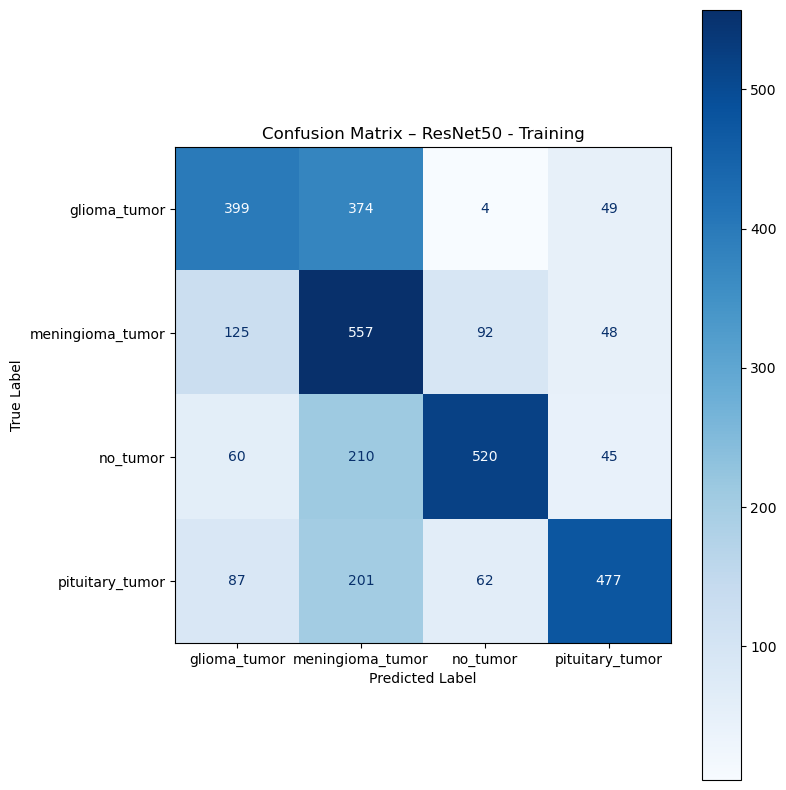

In [49]:

conf_matrix(y_train_encoded, ResNet_pred, model_name="ResNet50 - Training")

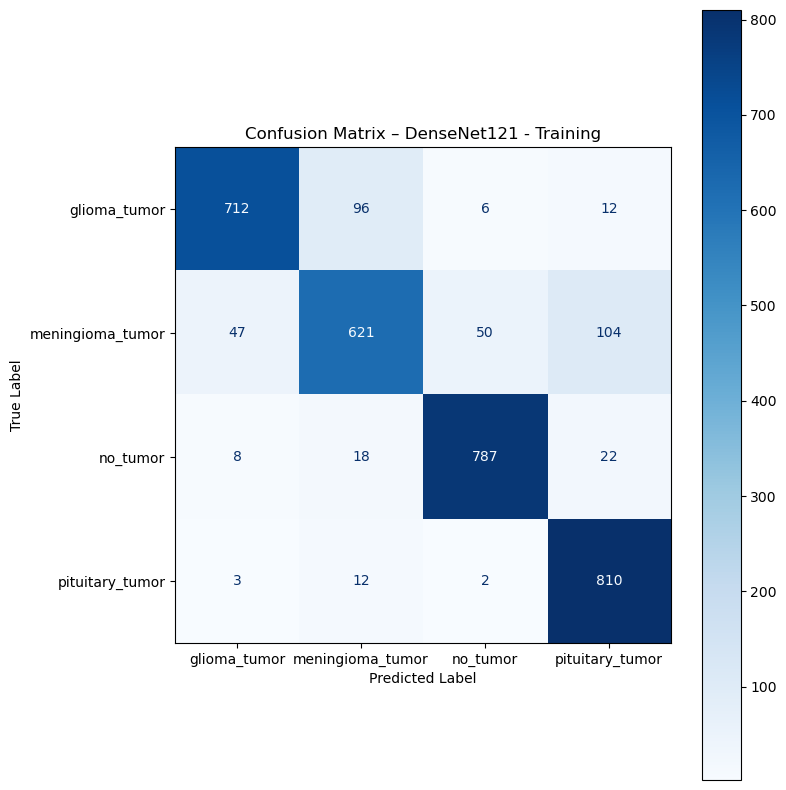

In [50]:
conf_matrix(y_train_encoded, model_densene_pred, model_name="DenseNet121 - Training")

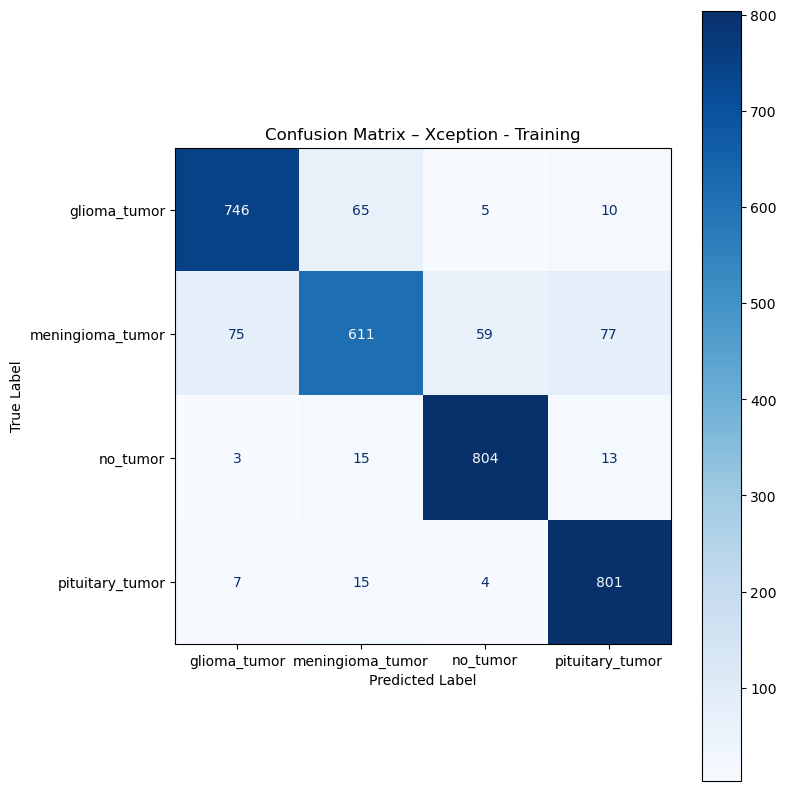

In [51]:
conf_matrix(y_train_encoded, model_xception_pred, model_name="Xception - Training")

## Model Optimization

**<span style="color: lightcoral;"> Xception Model Optimization</span>**


In [52]:
xception_model_2 = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

# Freeze base layers
xception_model_2.trainable = False

# Add custom classifier
x3_ = xception_model_2.output
x3_ = GlobalAveragePooling2D()(x3_)
x3_ = layers.Dense(256, activation='relu')(x3_) 
x3_ = Dropout(0.1)(x3_)

output_3_ = Dense(4, activation='softmax')(x3_)

model_xception_ = Model(inputs=xception_model_2.input, outputs=output_3_)
model_xception_.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
history_xception_ = model_xception_.fit(
    X_train_rgb, y_train_cat, 
    epochs= 5,
    batch_size=32
)

Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 406ms/step - accuracy: 0.6766 - loss: 0.7722
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 408ms/step - accuracy: 0.8621 - loss: 0.3628
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 411ms/step - accuracy: 0.8781 - loss: 0.3250
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 407ms/step - accuracy: 0.9295 - loss: 0.2012
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.9273 - loss: 0.2001


In [54]:
model_xception_pred_ = predictions(model_xception_, X_train_rgb )
model_xception_pred_

104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 412ms/step


array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [55]:
np.unique(model_xception_pred_)

array([0, 1, 2, 3], dtype=int64)

In [56]:
model_xception_pred_.shape

(3310,)

In [57]:
print("Xception Model Evaluation on Training Data")

evaluate(model_xception_, y_train_encoded, model_xception_pred_)

Xception Model Evaluation on Training Data
Precision: Out of all the predictions (y_pred), the model was correct 95.345 % of the time
Recall: Out of all the actual cases(y_train/y_test), the model successfully identified 95.217 % of the time
F1-score: Balance between precision and recall is 95.227


In [58]:
print("Xception Accuracy Score")
accuracy_score(y_train_encoded, model_xception_pred_)

Xception Accuracy Score


0.9522658610271904

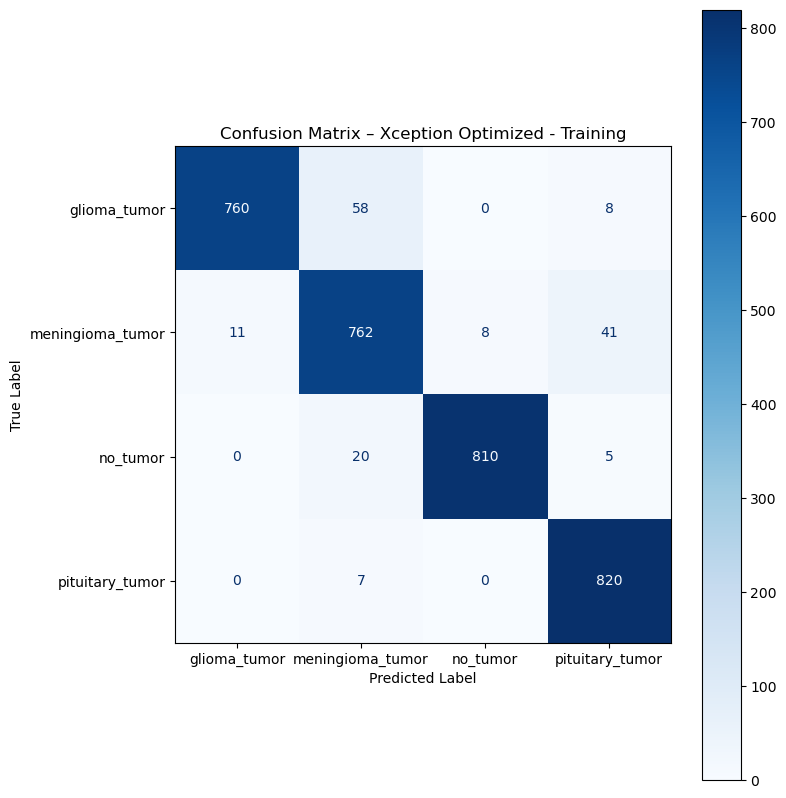

In [59]:
conf_matrix(y_train_encoded, model_xception_pred_, model_name="Xception Optimized - Training")

## Testing the Model Final Model

In [60]:
history_xception_ = model_xception_.fit(
    X_test_rgb, y_test_cat, 
    epochs= 5,
    batch_size=32)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - accuracy: 0.7640 - loss: 0.8921
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step - accuracy: 0.8046 - loss: 0.4935
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.8811 - loss: 0.3495
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.9213 - loss: 0.2591
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.9442 - loss: 0.1836


In [61]:
model_xception_pred_test = predictions(model_xception_, X_test_rgb )
model_xception_pred_test

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step


array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [62]:
np.unique(model_xception_pred_test)

array([0, 1, 2, 3], dtype=int64)

In [63]:
model_xception_pred_test.shape

(394,)

In [64]:
print("Xception Model Evaluation on Testing Data")

evaluate(model_xception_, y_test_encoded, model_xception_pred_test)

Xception Model Evaluation on Testing Data
Precision: Out of all the predictions (y_pred), the model was correct 96.991 % of the time
Recall: Out of all the actual cases(y_train/y_test), the model successfully identified 96.565 % of the time
F1-score: Balance between precision and recall is 96.680


In [65]:
print("Xception Accuracy Score - Test Data")
accuracy_score(y_test_encoded, model_xception_pred_test)

Xception Accuracy Score - Test Data


0.9644670050761421

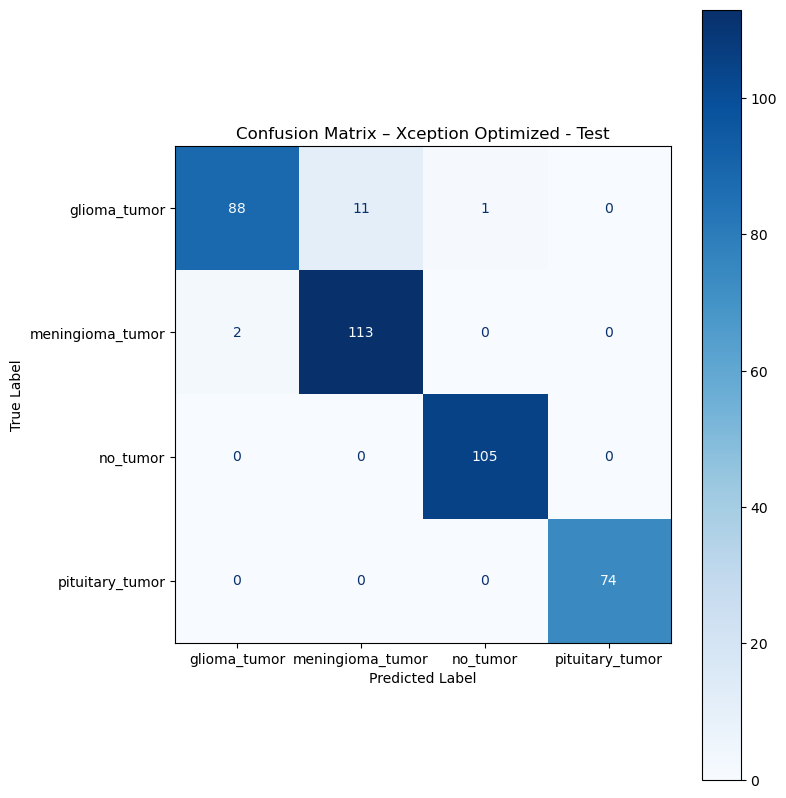

In [66]:
conf_matrix(y_test_encoded, model_xception_pred_test, model_name="Xception Optimized - Test")

After optimizing my Xception Model it performed at 95% and when I tested the model with the test data it performed at 9% accuracy. This means my model is performing incredibely well and it is not over fitting or underfitting. It is generalizing well to unseen examples, the preprocessing, architecture, and training pipeline are working nicely together.

## Testing the Model / Final Model

**<span style="color: lightcoral;">Xception Model Evaluation on Test Data</span>**


In [67]:
final_model_pred_x = predictions(model_xception_, X_test_rgb )
final_model_pred_x

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step


array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [68]:
np.unique(final_model_pred_x)

array([0, 1, 2, 3], dtype=int64)

In [69]:
final_model_pred_x.shape

(394,)

In [70]:
print("Xception Model Evaluation on Test Data")

evaluate(model_xception_, y_test_encoded, final_model_pred_x)

Xception Model Evaluation on Test Data
Precision: Out of all the predictions (y_pred), the model was correct 96.991 % of the time
Recall: Out of all the actual cases(y_train/y_test), the model successfully identified 96.565 % of the time
F1-score: Balance between precision and recall is 96.680


In [71]:
print("Xception Accuracy Score - Test Data")
accuracy_score(y_test_encoded, final_model_pred_x)

Xception Accuracy Score - Test Data


0.9644670050761421

In [ ]:
history_xception_ = model_xception_.fit(
    X_test_rgb, y_test_cat, 
    epochs=5,
    batch_size=32
)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step - accuracy: 0.9728 - loss: 0.1413
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.9796 - loss: 0.1339
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.9619 - loss: 0.1115
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.9912 - loss: 0.0730
Epoch 5/5
 8/13 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.9912 - loss: 0.0876

In [ ]:
model_xception_pred_2 = predictions(model_xception_, X_test_rgb )
model_xception_pred_2

In [ ]:
print("Xception Model Evaluation on Training Data")

evaluate(model_xception_, y_test_encoded, model_xception_pred_2)

In [ ]:
print("Xception Accuracy Score")
accuracy_score(y_test_encoded, model_xception_pred_2)